used tutorial: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/

# TO DO:


Find why sometimes we cannot find road blocks but cannot find a path.

Change it such that it is faster

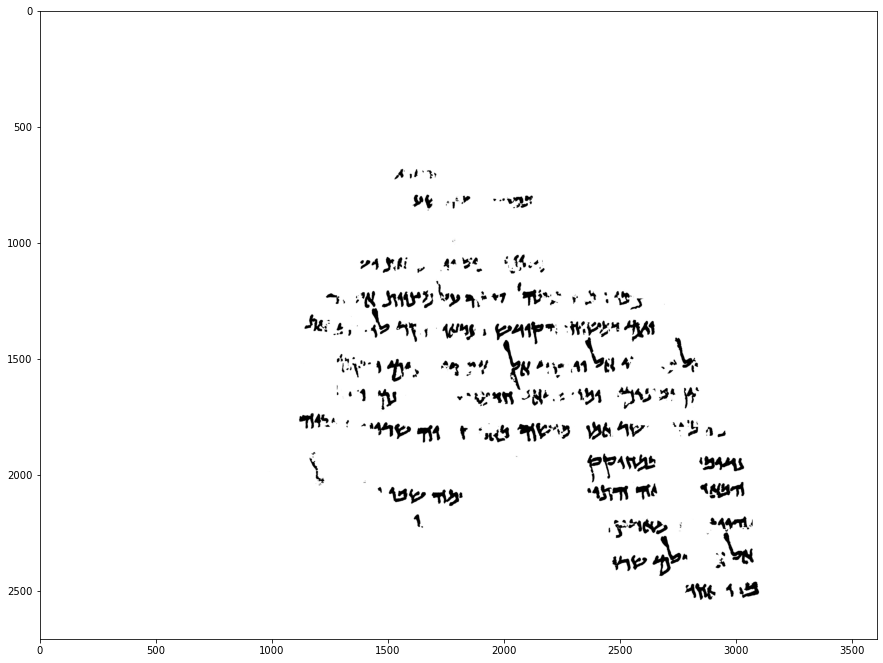

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
import numpy as np


easy_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
hard_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P22-Fg008-R-C01-R01-binarized.jpg' 
huge_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P344-Fg001-R-C01-R01-binarized.jpg'
half_sentences_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P106-Fg002-R-C01-R01-binarized.jpg'
divided_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P423-1-Fg002-R-C01-R01-binarized.jpg' 
curly_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P123-Fg002-R-C01-R01-binarized.jpg' 
vague_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P166-Fg007-R-C01-R01-binarized.jpg'

image2 = cv2.imread(half_sentences_scroll)
img_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15,15))
plt.axis()
plt.imshow(img_gray, cmap="gray")
plt.show()



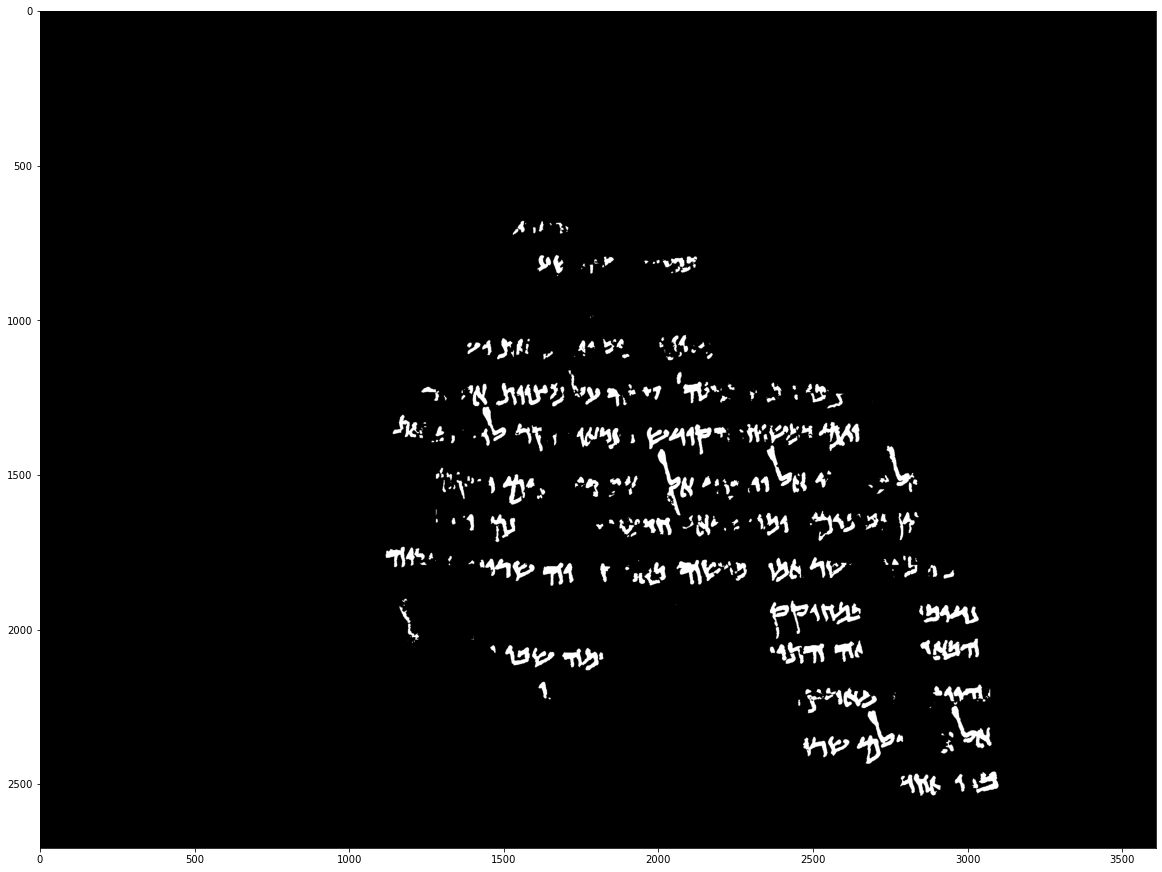

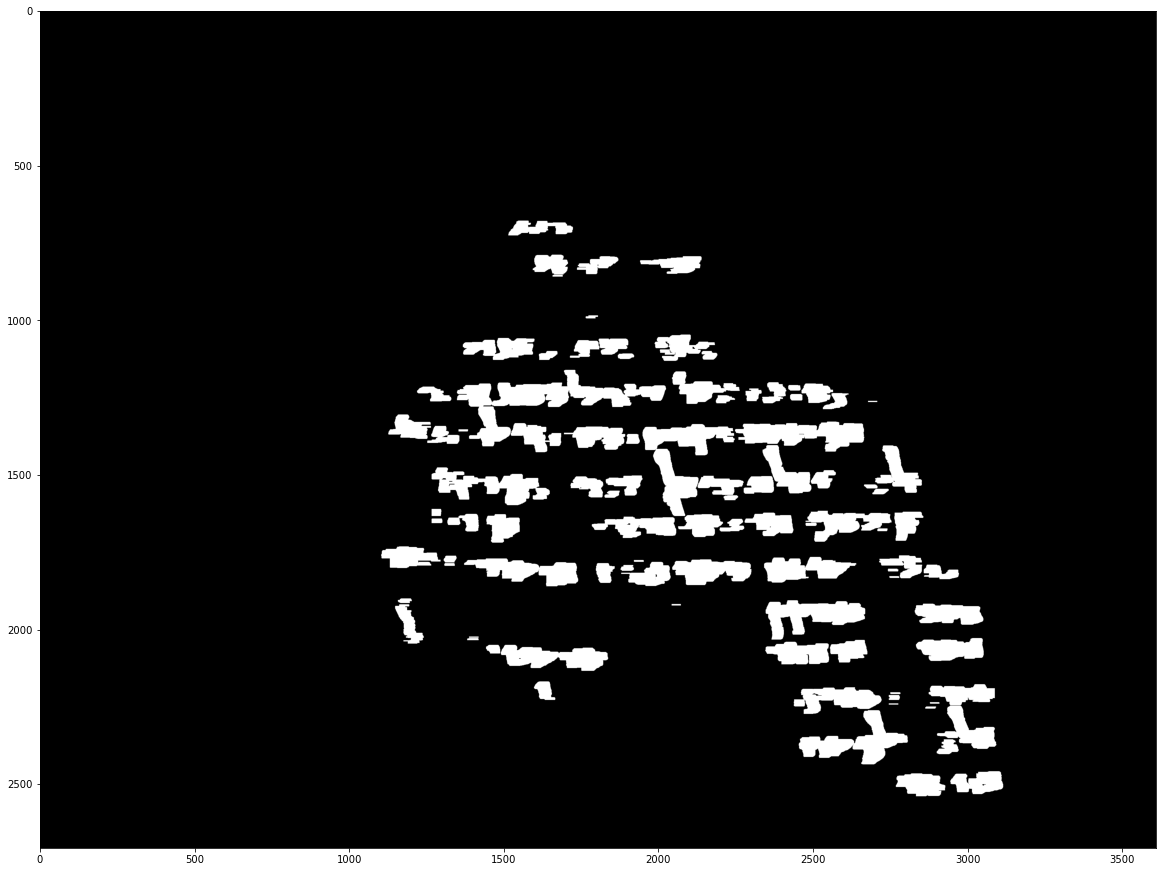

In [2]:
#maybe use this instead of the other gray image becaus here the small things are removed and we can find a better path i think.

def thresholding(image):
    _ ,thresh = cv2.threshold(image,80,255,cv2.THRESH_BINARY_INV)
    plt.figure(figsize=(20,20))
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img_gray)

#dilation
#We can change the dilation to create larger letters if we want to.first num is vertical, second num is horizontal dilation
#3,15 is the one used since the beginning, we can change to other settings if we like
kernel = np.ones((4,30), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

plt.figure(figsize=(20,20))
plt.imshow(dilated, cmap='gray')
plt.show()

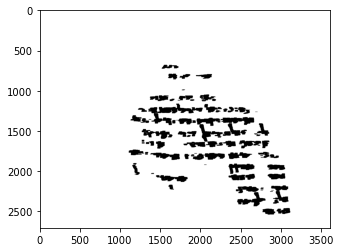

In [3]:
#Invert the image back from black background to white background, for the path finder. 
invert = cv2.bitwise_not(dilated)
plt.imshow(invert, cmap='gray')

img = invert

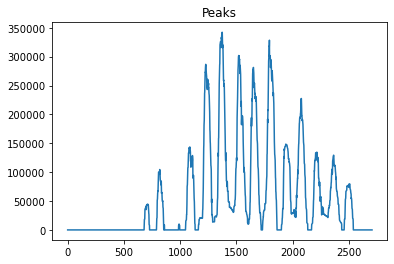

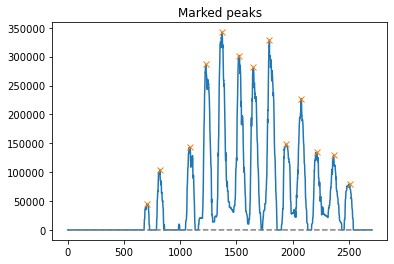

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def horizontal_projections(image):
    return np.sum(image, axis=1) 

hpp = horizontal_projections(dilated)
plt.plot(hpp)
plt.title("Peaks")
plt.show()


# The minimum_peak is just a treshold value for what number a peak minimum has to consist of. 
# The distance in the find_peaks() function seperates the peaks by a distance of minimum of 100. With the highest peak being selected. 
minimum_peak = int((np.max(hpp)-np.min(hpp))/12)
peaks, _ = find_peaks(hpp, height=minimum_peak, distance=100)
plt.plot(hpp)
plt.title("Marked peaks")
plt.plot(peaks, hpp[peaks], "x")
plt.plot(np.zeros_like(hpp), "--", color="gray")
plt.show()

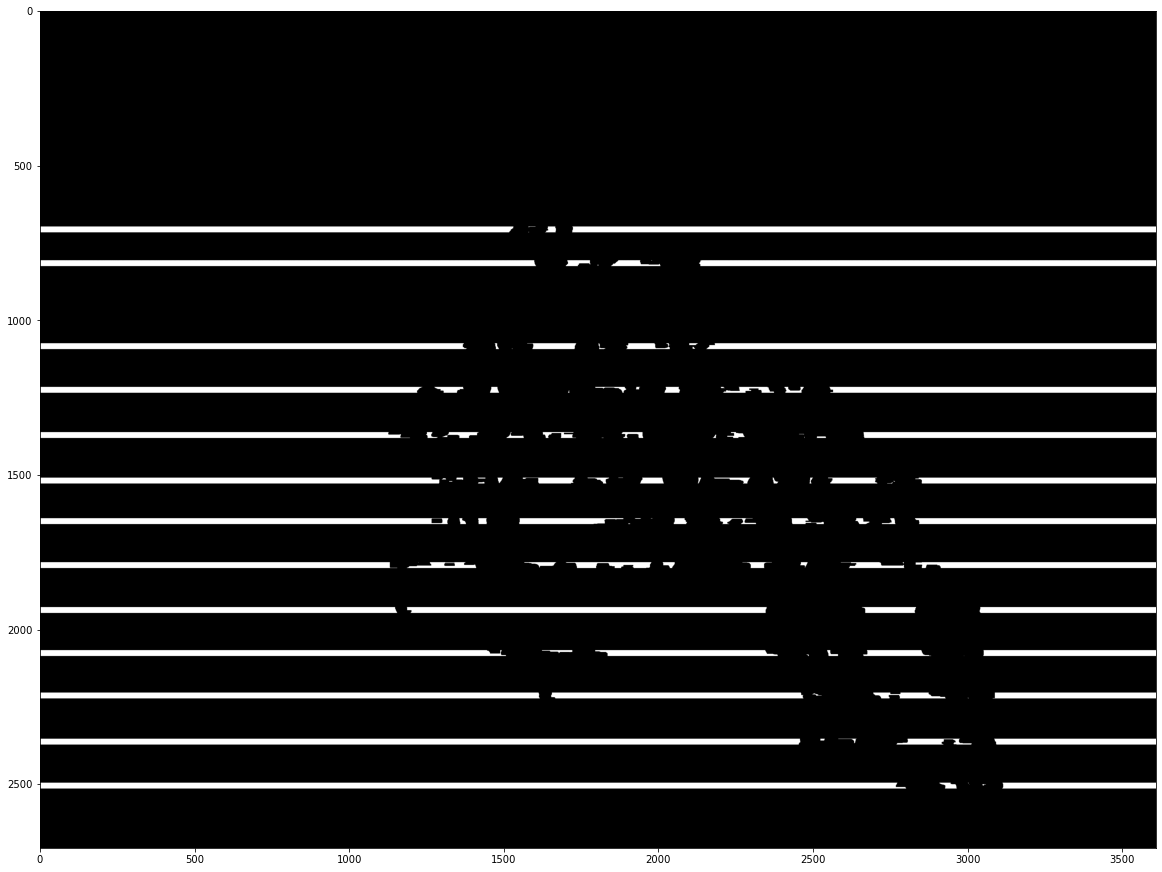

In [5]:
#Use the calculated peaks to create small areas of where there must be sentences. 
def find_not_peak_regions(hpp):
    not_peaks = []
    not_peaks_index = []
    count = 0
    x = 0
    line_size = 10
    for i, hppv in enumerate(hpp):
        if x > (len(peaks) - 1):
            not_peaks.append([i, hppv])
        elif i < (peaks[x] - line_size) or i > (peaks[x] + line_size):
            not_peaks.append([i, hppv])
        else:
            count += 1
            if count == ((line_size*2) - 1):
                x += 1
                count = 0
    return not_peaks

not_peaks = find_not_peak_regions(hpp)

not_peaks_index = np.array(not_peaks)[:,0].astype(int)


#Displays the image below
segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in not_peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(20,20))
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [6]:
#The Hpp_clusters is the black areas such that we have walking regions for the algorithm

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!! change this yourself still
#This function can still be changed to something easier I think

#Create walking regions in the image
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(not_peaks_index)

In [8]:
#Copied from the github mentioned above, adjusted for our problem. Created a range of goals.

#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    
    #print("start: " + str(start))
    #print("end: " + str(goal))
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    lower_limit = goal[0]
    upper_limit = goal[0] + lower_limit
    
    count = 0
    while oheap:
        count += 1
        
        current = heappop(oheap)[1]
        
        #If there is not a path break after 10 times the length of the input iterations
        if count > goal[1]*10:
            break
            
        #The goal of the path finder can be somewhere in the range of the walking region at the end
        if current[1] == goal[1] and (current[0] > lower_limit and current[0] < upper_limit):
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))      
    return []

In [9]:
#Copied from the github mentioned above


#Scan the paths to see if there are any blockers.
from skimage.filters import threshold_otsu
from skimage.util import invert

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

def path_exists(window_image):
    #very basic check first then proceed to A* check
    if 0 in horizontal_projections(window_image):
        return True
    
    padded_window = np.zeros((window_image.shape[0],1))
    world_map = np.hstack((padded_window, np.hstack((window_image,padded_window)) ) )
    path = np.array(astar(world_map, (int(world_map.shape[0]/2), 0), (int(world_map.shape[0]/2), world_map.shape[1])))
    if len(path) > 0:
        return True
    
    return False

def get_road_block_regions(nmap):
    road_blocks = []
    needtobreak = False
    print(nmap.shape[1])
    
    for col in range(nmap.shape[1]):
        start = col
        end = col+20
        if end > nmap.shape[1]-1:
            end = nmap.shape[1]-1
            needtobreak = True

        if path_exists(nmap[:, start:end]) == False:
            road_blocks.append(col)

        if needtobreak == True:
            break
            
    #road_blocks = the x values of were the road_block is. not in which cluster but at what x values we can find the road blocks
    print(road_blocks)
    return road_blocks


def group_the_road_blocks(road_blocks):
    #group the road blocks
    road_blocks_cluster_groups = []
    road_blocks_cluster = []
    size = len(road_blocks)
    for index, value in enumerate(road_blocks):
        road_blocks_cluster.append(value)
        if index < size-1 and (road_blocks[index+1] - road_blocks[index]) > 1:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

        if index == size-1 and len(road_blocks_cluster) > 0:
            road_blocks_cluster_groups.append([road_blocks_cluster[0], road_blocks_cluster[len(road_blocks_cluster)-1]])
            road_blocks_cluster = []

    return road_blocks_cluster_groups

#We use the dilated and inverted image for the path finder, such that we do not go through letters
binary_image = get_binary(img)

for cluster_of_interest in hpp_clusters:
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    road_blocks = get_road_block_regions(nmap)
    road_blocks_cluster_groups = group_the_road_blocks(road_blocks)
    #create the doorways
    #remove the road blocks such that the path finder can do a better job. 
    for index, road_blocks in enumerate(road_blocks_cluster_groups):
        #print("second loop")
        if nmap.shape[0] == 0:
            continue
        else:
            window_image = nmap[:, road_blocks[0]: road_blocks[1]+10]
            binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:][:, road_blocks[0]: road_blocks[1]+10][int(window_image.shape[0]/2),:] *= 0

3608
nmap: 698
[]
3608
nmap: 89
[]
3608
nmap: 248
[]
3608
nmap: 121
[]
3608
count: 221
count: 221
count: 221
count: 221
count: 221
count: 221
count: 221
count: 221
count: 221
count: 221
nmap: 126
[1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432]
3608
count: 221
nmap: 127
[1993]
3608
nmap: 111
[]
3608
nmap: 122
[]
3608
nmap: 125
[]
3608
nmap: 119
[]
3608
nmap: 117
[]
3608
nmap: 129
[]
3608
nmap: 122
[]
3608
nmap: 191
[]


In [10]:
#If we can not find a path from left to right we create a straight line here
line_new = []
size_cluster = int(nmap.shape[0] /2)
for i in range(nmap.shape[1] -1):
    line_new.append([size_cluster, nmap.shape[1]-i -1])
    line = []
line_new = np.asarray(line_new)

In [12]:
#Its time to segment all the lines using the A* algorithm
line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    
    #The goal given is the middle of the walking region. But we adjusted in the path finder to the complete range.
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2), nmap.shape[1]-1)))
   
    #Finding a path is impossible
    if path.shape[0] == 0:
        line_new = []
        size_cluster = int(nmap.shape[0] /2)
        for i in range(nmap.shape[1] -1):
            line_new.append([size_cluster, nmap.shape[1]-i -1])
            line = []
        line_new = np.asarray(line_new)
        offset_from_top = cluster_of_interest[0]
        line_new[:,0] += offset_from_top
        line_segments.append(line_new)
    else:
        print(nmap.shape[0])
        print(path.shape)
        offset_from_top = cluster_of_interest[0]
        path[:,0] += offset_from_top
        line_segments.append(path)

count: 3612
698
(3607, 2)
Shape : (699,)
offset_from_top: 0
path: [[ 350 3607]
 [ 349 3606]
 [ 349 3605]
 ...
 [ 349    3]
 [ 349    2]
 [ 349    1]]
path[:,0]: [350 349 349 ... 349 349 349]
count: 3612
89
(3607, 2)
Shape : (90,)
offset_from_top: 718
path: [[ 763 3607]
 [ 762 3606]
 [ 762 3605]
 ...
 [ 762    3]
 [ 762    2]
 [ 762    1]]
path[:,0]: [763 762 762 ... 762 762 762]
count: 3612
248
(3607, 2)
Shape : (249,)
offset_from_top: 827
path: [[ 952 3607]
 [ 951 3606]
 [ 951 3605]
 ...
 [ 951    3]
 [ 951    2]
 [ 951    1]]
path[:,0]: [952 951 951 ... 951 951 951]
count: 3612
121
(3607, 2)
Shape : (122,)
offset_from_top: 1095
path: [[1156 3607]
 [1155 3606]
 [1155 3605]
 ...
 [1155    3]
 [1155    2]
 [1155    1]]
path[:,0]: [1156 1155 1155 ... 1155 1155 1155]
count: 36071
offset_from_top: 1236
line: [[1299 3607]
 [1299 3606]
 [1299 3605]
 ...
 [1299    3]
 [1299    2]
 [1299    1]]
line[:,0]: [1299 1299 1299 ... 1299 1299 1299]
count: 36071
offset_from_top: 1382
line: [[1445 3607]

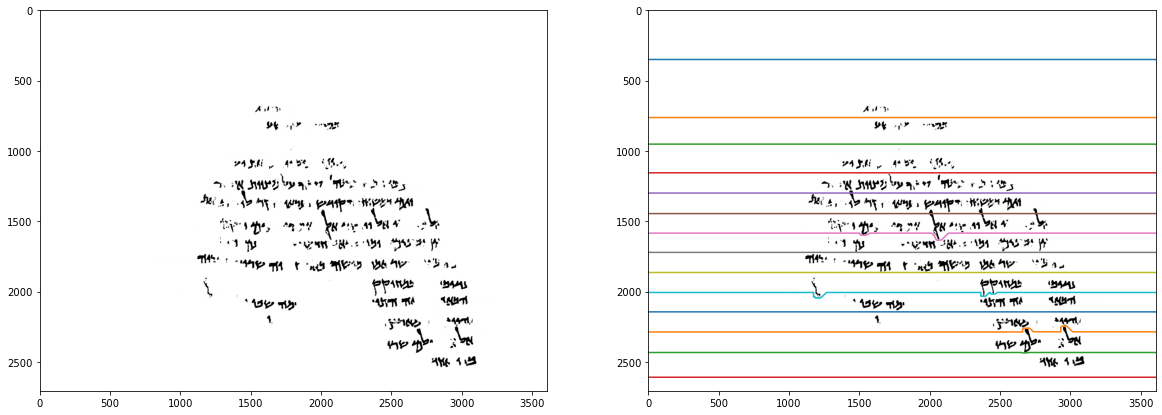

In [14]:
#Print the created path throught the first inputted image
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in line_segments:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].axis()
ax[0].axis()
ax[1].imshow(image2, cmap="gray")
ax[0].imshow(image2, cmap="gray")

In [15]:
# cluster_of_interest = hpp_clusters[2]
# offset_from_top = cluster_of_interest[0]
# nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
# plt.figure(figsize=(20,20))
# plt.imshow(invert(nmap), cmap="gray")

# path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
# plt.plot(path[:,1], path[:,0])

Character segmentation

In [16]:
### add an extra line to the line segments array which represents the last bottom row on the image
# #is this really necessary? 


# last_bottom_row = np.flip(np.column_stack(((np.ones((image2.shape[1],))*image2.shape[0]), np.arange(image2.shape[1]))).astype(int), axis=0)
# line_segments.append(last_bottom_row)

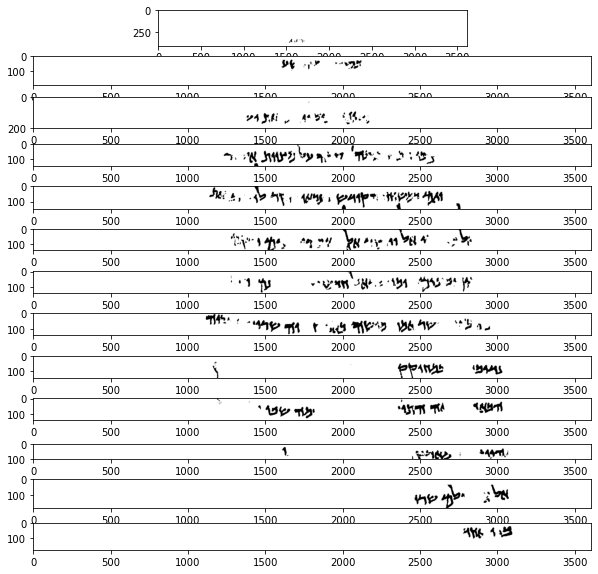

In [17]:
#Copied from the github mentioned above

line_images = []
def extract_line_from_image(img, lower_line, upper_line):
    lower_boundary = np.min(lower_line[:, 0])
    upper_boundary = np.min(upper_line[:, 0])
    img_copy = np.copy(img)
    #print(img_copy.shape)
    r, c = img_copy.shape
    for index in range(c-1):
        img_copy[0:lower_line[index, 0], index] = 255
        img_copy[upper_line[index, 0]:r, index] = 255
    
    return img_copy[lower_boundary:upper_boundary, :]



line_count = len(line_segments)
fig, ax = plt.subplots(figsize=(10,10), nrows=line_count-1)
for line_index in range(line_count-1):
    line_image = extract_line_from_image(img_gray, line_segments[line_index], line_segments[line_index+1])
    line_images.append(line_image)
    ax[line_index].imshow(line_image, cmap="gray")

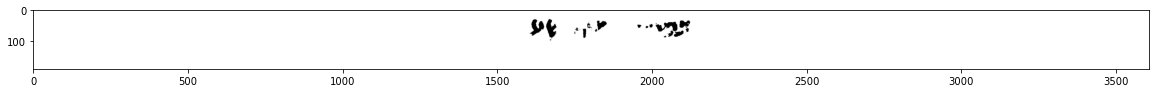

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(line_images[1], cmap="gray")
plt.show()

In [19]:
from skimage.filters import threshold_otsu

#binarize the image, guassian blur will remove any noise in the image
first_line = line_images[1]
thresh = threshold_otsu(first_line)
binary = first_line > thresh

# # find the vertical projection by adding up the values of all pixels along rows
# vertical_projection = np.sum(binary, axis=0)

# # plot the vertical projects
# fig, ax = plt.subplots(nrows=2, figsize=(20,10))
# plt.xlim(0, first_line.shape[1])
# ax[0].imshow(binary, cmap="gray")
# ax[1].plot(vertical_projection)

In [20]:
len(line_images)

13

Heightforif: 18
Widthforif: 27
Height: 18
Width: 27

Heightforif: 1
Widthforif: 1
Height: 1
Width: 1

Heightforif: 3
Widthforif: 3
Height: 3
Width: 3

Heightforif: 4
Widthforif: 6
Height: 4
Width: 6

Heightforif: 2
Widthforif: 2
Height: 2
Width: 2

Heightforif: 25
Widthforif: 13
Height: 25
Width: 13

Heightforif: 1
Widthforif: 1
Height: 1
Width: 1

Heightforif: 2
Widthforif: 2
Height: 2
Width: 2

Heightforif: 19
Widthforif: 29
Height: 19
Width: 29

Heightforif: 23
Widthforif: 23
Height: 23
Width: 23

Heightforif: 3
Widthforif: 2
Height: 3
Width: 2

Heightforif: 16
Widthforif: 9
Height: 16
Width: 9

Heightforif: 15
Widthforif: 13
Height: 15
Width: 13

Heightforif: 18
Widthforif: 11
Height: 18
Width: 11

Heightforif: 1
Widthforif: 2
Height: 1
Width: 2

Heightforif: 49
Widthforif: 51
Height: 49
Width: 51

Heightforif: 13
Widthforif: 16
Height: 13
Width: 16

Heightforif: 1
Widthforif: 1
Height: 1
Width: 1

Heightforif: 26
Widthforif: 15
Height: 26
Width: 15

Heightforif: 32
Widthforif: 15


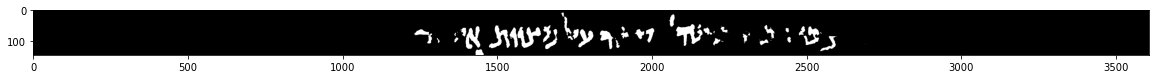

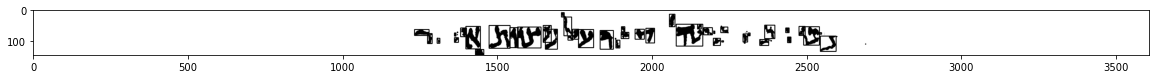

In [21]:
MINSIZE = 0 
MAXSIZE = 500

gray = line_images[3]
#gray = original
original = gray.copy()
thresholded = thresholding(gray)


ROI_number = 0
cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
boxcoordinates = []
for c in cnts:
    topleftx, toplefty, width, height = cv2.boundingRect(c)
    #print("Heightforif: " +str(height))
    #print("Widthforif: " +str(width))
    
    #Reject contours that are too big or small to be likely letters
    if height<MINSIZE or width<MINSIZE:
        continue

    if height>MAXSIZE or width>MAXSIZE:
        continue
    
    #print("Height: " +str(height))
    #print("Width: " +str(width))
    #print()
    cv2.rectangle(gray, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
    boxcoordinates.append((topleftx, toplefty, width, height))
    
plt.figure(figsize=(20,20))
plt.imshow(gray, cmap="gray")
plt.show()


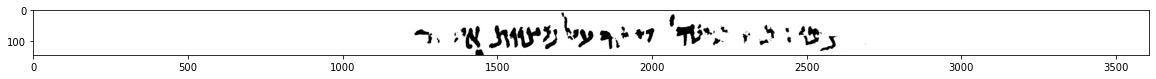

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(original, cmap="gray")
plt.show()